# Dinamica

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import CircuitSampler, StateFn

import qiskit
from qiskit               import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute, Aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow              import PauliSumOp
from qiskit.quantum_info        import SparsePauliOp

import math
import numpy as np
from numpy import linalg

from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise


from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.opflow import I, X, Y, Z, One, Zero

from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex
from qiskit import QuantumRegister

from qiskit import IBMQ

In [38]:
def H_ising(num_qubits,J,b):
    m=num_qubits-1
    n=num_qubits-2
    G=b*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(m-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    return hamiltonian

In [2]:
def U_ising(num_qubits,J,b,t):
    # Compute Ising Hamiltonian 
    H = H_ising(num_qubits,J,b)
    
    # Return the exponential of -i multipled by time t multipled by the Ising Hamiltonian 
    return (t * H).exp_i()

## Evoluzione dello stato 0010 classica

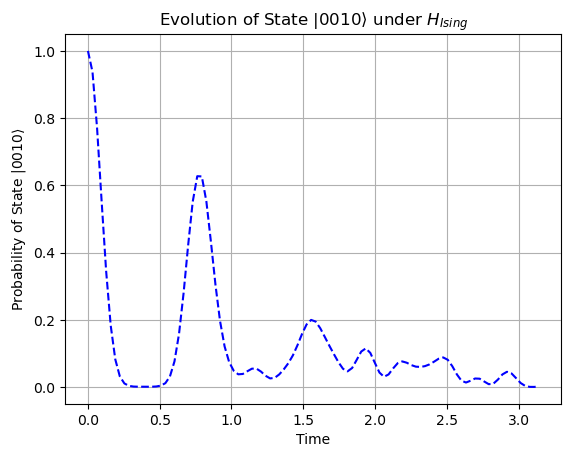

In [39]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)
num_qubits=4
J=-1
b=4

# Define initial state 
initial_state = Zero^One^Zero^Zero

probs_0010_exact = [np.abs((~initial_state @ U_ising(num_qubits,J,b,float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |0010>
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="blue")
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|0010\rangle$')
plt.title(r'Evolution of State $|0010\rangle$ under $H_{Ising}$')
plt.grid()
plt.show()

## Evoluzione stato 0010 quantistica

In [4]:
def Ising_Trotter(num_qubits,J,b,trotter_steps,t):
    
    # Given a target time and a number of Trotter steps, every step will evolve the 
    # circuit for a time step dt = target_time/trotter_steps
    dt = t/trotter_steps

    # Initialize quantum circuit for num_qubits
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr) 
    
    for _ in range(trotter_steps):
        for i in range(0, num_qubits):
            qc.rx(b*2*dt,i)

        for i in range(0, num_qubits - 1):
            qc.rzz(J*2*dt,i,i+1)
            
        # To separate the different Trotter steps
        qc.barrier()


    return qc

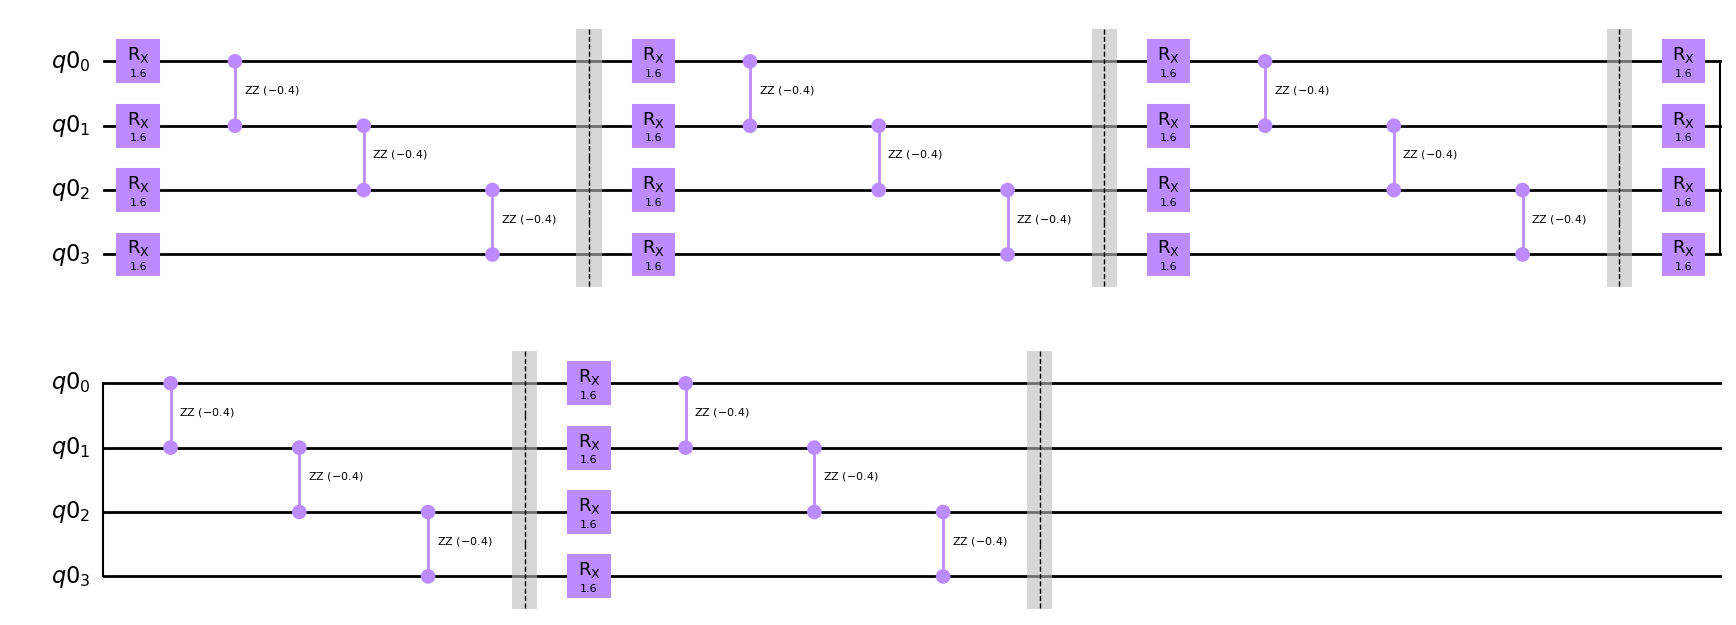

In [5]:
Ising_Trotter(num_qubits,J,b,5,1).draw('mpl')

In [6]:
provider = IBMQ.enable_account('77dda7985ecda9fa85b6dcc27eea16f88f9d96e9732aea4d184e9270ec00a8f76ec5e14f289d0a7c28ab9b755d5e205e42781d238358bc64675bcc8abbda9c1f')
#provider   = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [7]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [8]:
nshots=8000
HW = 'ibmq_manila'
BK = "noisy2" # "noiseless", "hardware"

if BK == "noiseless1":
    backend =Aer.get_backend("statevector_simulator")
    
if BK == "noiseless2":
    backend     = QasmSimulator(shots=nshots)
    
if BK == "noisy1":
    device = provider.get_backend(HW)
    noise_model = NoiseModel.from_backend(device)
    backend = QasmSimulator(method="statevector",
                        noise_model=noise_model)
    
if BK == "noisy2":
    device = provider.get_backend(HW)
    noise_model = NoiseModel.from_backend(device)
    backend     = QasmSimulator(noise_model=noise_model, shots=nshots)
    
if BK == "hardware":
    
    device = provider.get_backend(HW)
    prop = device.properties()
    
    quantum_instance = QuantumInstance(device,
                                       shots=nshots)

In [ ]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 8, 12 and 15 Trotter steps

probs_0010_trott = {8:[],12:[],15:[]}

expectation = PauliExpectation() 
sampler     = CircuitSampler(backend)

## We want to measure |0010><0010|
prj = StateFn((1/16)*(I+Z)^(I-Z)^(I+Z)^(I+Z),is_measurement=True)

for n in probs_0010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(4)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(2)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_0010_trott[n].append(trott_sample.eval().real)

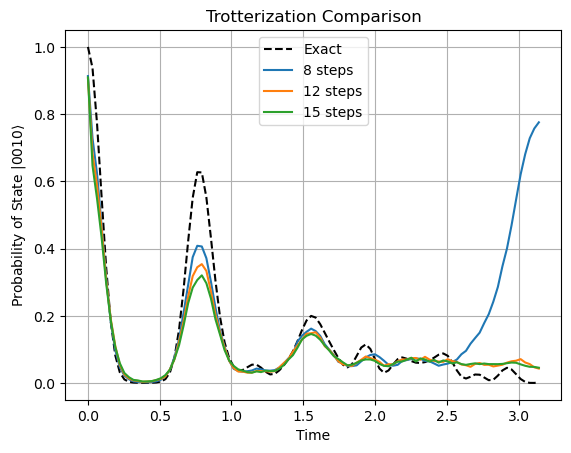

In [14]:
# Now plot the comparison
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_0010_trott.keys()):
    plt.plot(ts, probs_0010_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|0010\rangle$')
plt.title(r'Trotterization Comparison')
plt.legend()
plt.grid()
plt.show()

# Magnetizzazione classica

In [15]:
J =-1
c_times = np.linspace(0,0.5*math.pi/abs(J),1000)
q_times = np.linspace(0,0.5*math.pi/abs(J),10)

#Initial state

psi0=Zero^One^Zero^Zero

sz1_t = np.zeros(len(c_times))
sz2_t = np.zeros(len(c_times))
sz3_t = np.zeros(len(c_times))
sz4_t = np.zeros(len(c_times))
sz=np.zeros(len(c_times))

sz1 = I^I^I^Z
sz2 = I^I^Z^I
sz3 = I^Z^I^I
sz4 = Z^I^I^I

for i in range(len(c_times)):
    
    t = c_times[i]
    psi_t = U_ising(num_qubits,J,b,float(t)) @ psi0
    sz1_t[i] = np.real((~psi_t @ sz1 @ psi_t).eval())
    sz2_t[i] = np.real((~psi_t @ sz2 @ psi_t).eval())
    sz3_t[i] = np.real((~psi_t @ sz3 @ psi_t).eval())
    sz4_t[i] = np.real((~psi_t @ sz4 @ psi_t).eval())
    sz[i]=sz1_t[i]+sz2_t[i]+sz3_t[i]+sz4_t[i]

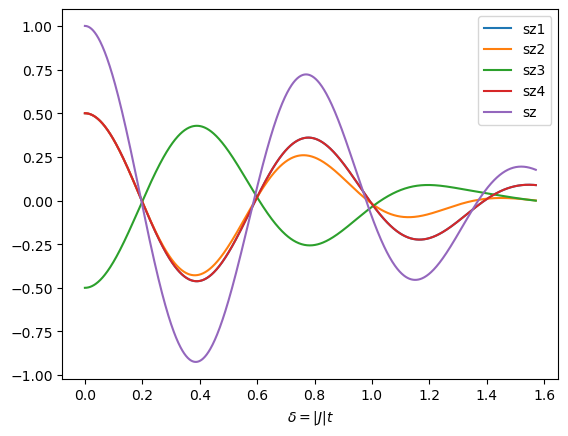

In [16]:
plt.plot(abs(J)*c_times,0.5*sz1_t)
plt.plot(abs(J)*c_times,0.5*sz2_t)
plt.plot(abs(J)*c_times,0.5*sz3_t)
plt.plot(abs(J)*c_times,0.5*sz4_t)
plt.plot(abs(J)*c_times,0.5*sz)
plt.legend(['sz1','sz2','sz3','sz4','sz'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

# Magnetizzazione quantistica

In [18]:
shots=8000

qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

backend = provider.get_backend(HW)

sim_manila = QasmSimulator.from_backend(backend,shots=shots)

t_qc = transpile(meas_calibs, sim_manila)

qobj = assemble(t_qc, shots=10000)
cal_results = sim_manila.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [23]:
### Digital quantum simulation of the Ising model using qiskit

sz1q_t = np.zeros(len(q_times))
sz2q_t = np.zeros(len(q_times))
sz3q_t = np.zeros(len(q_times))
sz4q_t = np.zeros(len(q_times))
szq = np.zeros(len(q_times))

sz1qm_t = np.zeros(len(q_times))
sz2qm_t = np.zeros(len(q_times))
sz3qm_t = np.zeros(len(q_times))
sz4qm_t = np.zeros(len(q_times))
szqm = np.zeros(len(q_times))

num_qubits=4

# Run the quantum algorithm

n=15

for k, sim_t in enumerate(q_times):
    trott_qr = QuantumRegister(4)
    
    trott_qc = QuantumCircuit(trott_qr)
    
    trott_qc.x(2)
    
    #Trotterization in order to use the previous circuit
    
    trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
    
    trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
    
    # Measure
    
    trott_qc.measure_all()
    
    # Run the quantum algorithm
    
    job = execute(trott_qc, sim_manila)
    result = job.result()
    counts = result.get_counts()
    
    # Post processing of outcomes to get sz expectation values

    sz1q = 0
    sz2q = 0
    sz3q = 0
    sz4q = 0
    
    for key,value in counts.items():
        if key == '0000':
            sz1q += value
            sz2q += value
            sz3q += value
            sz4q += value
        elif key == '1000':
            sz1q += value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '0100':
            sz1q += value
            sz2q += value
            sz3q -= value
            sz4q += value
        elif key == '0010':
            sz1q += value
            sz2q -= value
            sz3q += value
            sz4q += value
        elif key == '0001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q += value
        elif key == '1100':
            sz1q += value
            sz2q += value
            sz3q -= value
            sz4q -= value
        elif key == '1010':
            sz1q += value
            sz2q -= value
            sz3q += value
            sz4q -= value
        elif key == '1001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '0110':
            sz1q += value
            sz2q -= value
            sz3q -= value
            sz4q += value
        elif key == '0011':
            sz1q -= value
            sz2q -= value
            sz3q += value
            sz4q += value
        elif key == '1110':
            sz1q += value
            sz2q -= value
            sz3q -= value
            sz4q -= value
        elif key == '0111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
            sz4q += value
        elif key == '1011':
            sz1q -= value
            sz2q -= value
            sz3q += value
            sz4q -= value
        elif key == '1101':
            sz1q -= value
            sz2q += value
            sz3q -= value
            sz4q -= value
        elif key == '1001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '1111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
            sz4q -= value
      
    
    sz1q_t[k] = sz1q/shots
    sz2q_t[k] = sz2q/shots
    sz3q_t[k] = sz3q/shots
    sz4q_t[k] = sz4q/shots
    szq[k]= sz1q_t[k]+sz2q_t[k]+sz3q_t[k]+sz4q_t[k]
    
    #Error Mitigation

    mitigated_results = meas_filter.apply(result)
    mitigated_counts = mitigated_results.get_counts()
    
    sz1qm = 0
    sz2qm = 0
    sz3qm = 0
    sz4qm = 0

    for key,value in mitigated_counts.items():
        if key == '0000':
            sz1qm += value
            sz2qm += value
            sz3qm += value
            sz4qm += value
        elif key == '1000':
            sz1qm += value
            sz2qm += value
            sz3qm += value
            sz4qm -= value
        elif key == '0100':
            sz1qm += value
            sz2qm += value
            sz3qm -= value
            sz4qm += value
        elif key == '0010':
            sz1qm += value
            sz2qm -= value
            sz3qm += value
            sz4qm += value
        elif key == '0001':
            sz1qm -= value
            sz2qm += value
            sz3qm += value
            sz4qm += value
        elif key == '1100':
            sz1qm += value
            sz2qm += value
            sz3qm -= value
            sz4qm -= value
        elif key == '1010':
            sz1qm += value
            sz2qm -= value
            sz3qm += value
            sz4qm -= value
        elif key == '1001':
            sz1qm -= value
            sz2qm += value
            sz3qm += value
            sz4qm -= value
        elif key == '0110':
            sz1qm += value
            sz2qm -= value
            sz3qm -= value
            sz4qm += value
        elif key == '0011':
            sz1qm -= value
            sz2qm -= value
            sz3qm += value
            sz4qm += value
        elif key == '1110':
            sz1qm += value
            sz2qm -= value
            sz3qm -= value
            sz4qm -= value
        elif key == '0111':
            sz1qm -= value
            sz2qm -= value
            sz3qm -= value
            sz4qm += value
        elif key == '1011':
            sz1qm -= value
            sz2qm -= value
            sz3qm += value
            sz4qm -= value
        elif key == '1101':
            sz1qm -= value
            sz2qm += value
            sz3qm -= value
            sz4qm -= value
        elif key == '1001':
            sz1qm -= value
            sz2qm += value
            sz3qm += value
            sz4qm -= value
        elif key == '1111':
            sz1qm -= value
            sz2qm -= value
            sz3qm -= value
            sz4qm -= value

    sz1qm_t[k] = sz1qm/shots
    sz2qm_t[k] = sz2qm/shots
    sz3qm_t[k] = sz3qm/shots
    sz4qm_t[k] = sz4qm/shots
    szqm[k]= sz1qm_t[k]+sz2qm_t[k]+sz3qm_t[k]+sz4qm_t[k]


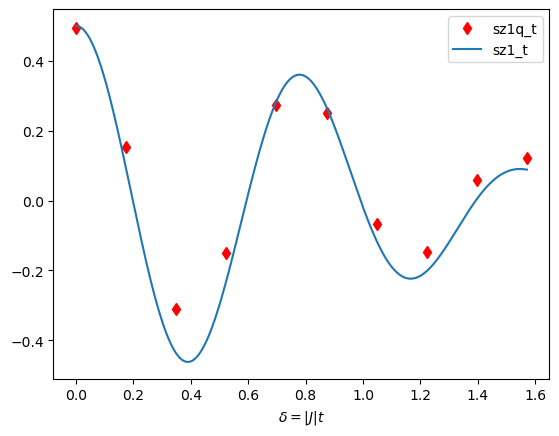

In [24]:
plt.plot(abs(J)*q_times,0.5*sz1q_t,'rd')
plt.plot(abs(J)*c_times,0.5*sz1_t)
plt.legend(['sz1q_t','sz1_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

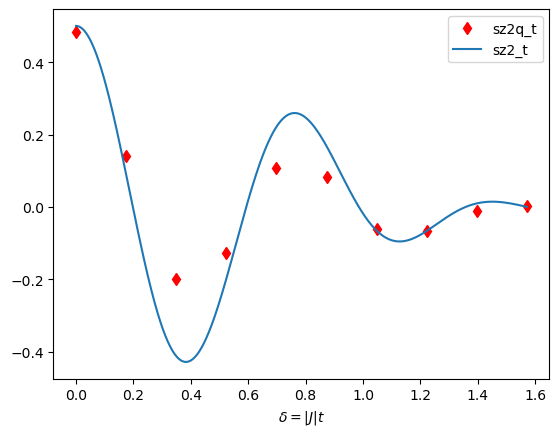

In [25]:
plt.plot(abs(J)*q_times,0.5*sz2q_t,'rd')
plt.plot(abs(J)*c_times,0.5*sz2_t)
plt.legend(['sz2q_t','sz2_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

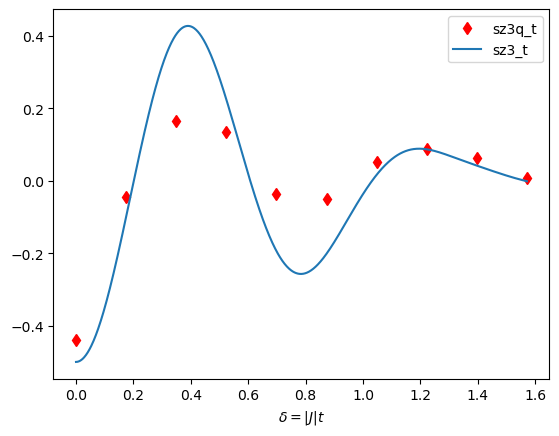

In [26]:
plt.plot(abs(J)*q_times,0.5*sz3q_t,'rd')
plt.plot(abs(J)*c_times,0.5*sz3_t)
plt.legend(['sz3q_t','sz3_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

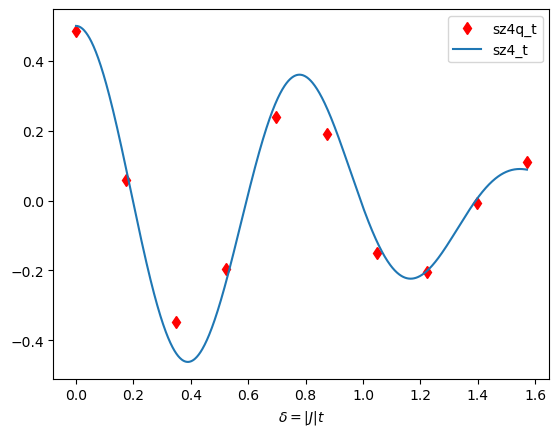

In [27]:
plt.plot(abs(J)*q_times,0.5*sz4q_t,'rd')
plt.plot(abs(J)*c_times,0.5*sz4_t)
plt.legend(['sz4q_t','sz4_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

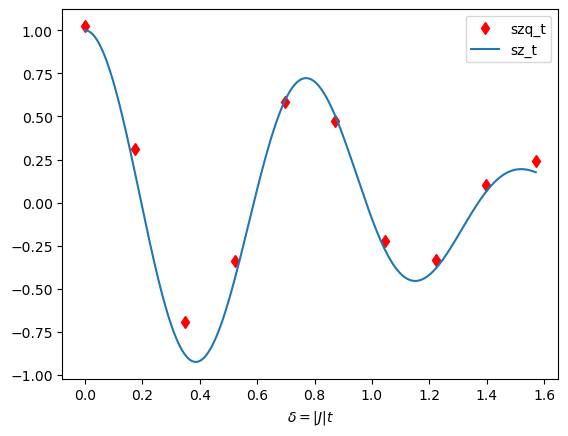

In [28]:
plt.plot(abs(J)*q_times,0.5*szq,'rd')
plt.plot(abs(J)*c_times,0.5*sz)
plt.legend(['szq_t','sz_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

## Mitigated Plots

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram([counts, mitigated_counts], legend=['noisy', 'mitigated'])

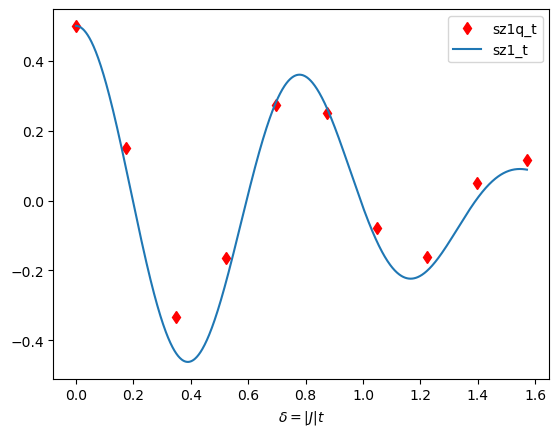

In [29]:
plt.plot(abs(J)*q_times,0.5*sz1qm_t,'rd')
plt.plot(abs(J)*c_times,0.5*sz1_t)
plt.legend(['sz1q_t','sz1_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

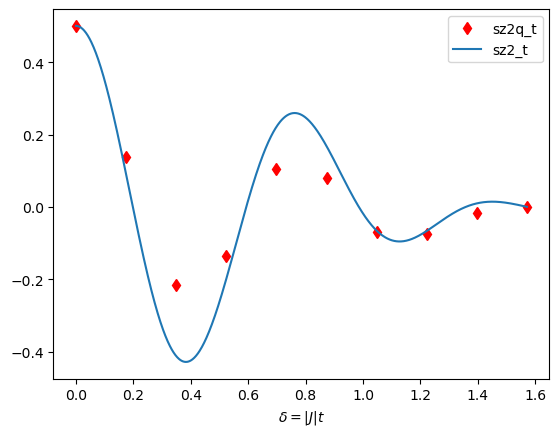

In [30]:
plt.plot(abs(J)*q_times,0.5*sz2qm_t,'rd')
plt.plot(abs(J)*c_times,0.5*sz2_t)
plt.legend(['sz2q_t','sz2_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

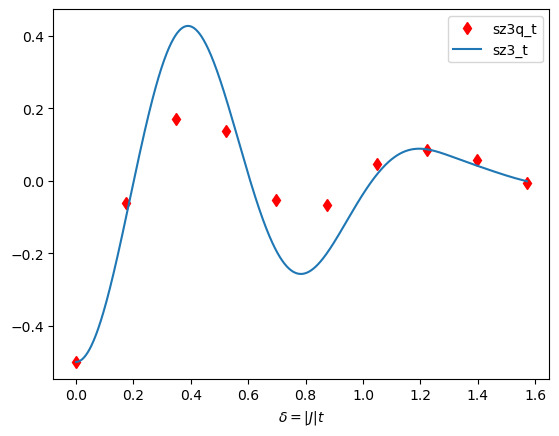

In [31]:
plt.plot(abs(J)*q_times,0.5*sz3qm_t,'rd')
plt.plot(abs(J)*c_times,0.5*sz3_t)
plt.legend(['sz3q_t','sz3_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

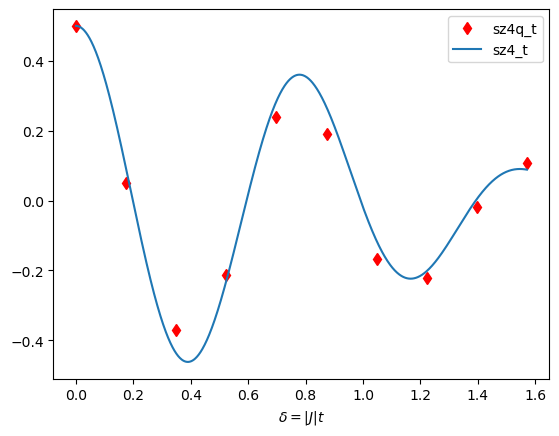

In [32]:
plt.plot(abs(J)*q_times,0.5*sz4qm_t,'rd')
plt.plot(abs(J)*c_times,0.5*sz4_t)
plt.legend(['sz4q_t','sz4_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

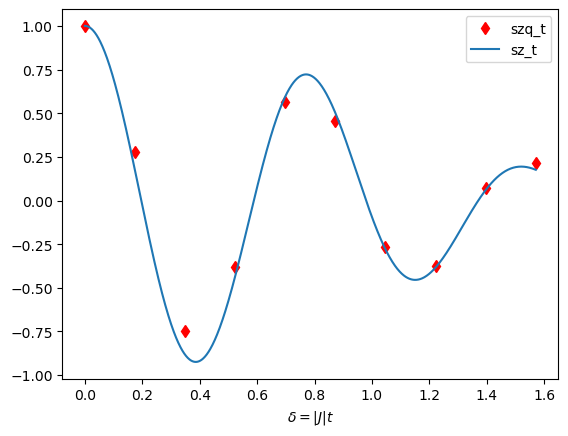

In [34]:
plt.plot(abs(J)*q_times,0.5*szqm,'rd')
plt.plot(abs(J)*c_times,0.5*sz)
plt.legend(['szq_t','sz_t'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()